In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import f1_score, auc, plot_confusion_matrix

import joblib

In [27]:
# Import data from csv
small_df = pd.read_csv('../datasets/sampled/downsample_small.csv')
balanced_df = pd.read_csv('../datasets/sampled/downsample_full.csv')

In [28]:
category_list = [
    'appliances',
    'arts_crafts_and_sewing',
    'automotive',
    'baby',
    'beauty',
    'cell_phones_and_accessories',
    'clothing_shoes_and_jewelry',
    'electronics',
    'grocery_and_gourmet_food',
    'health_and_personal_care',
    'home_and_kitchen',
    'industrial_and_scientific',
    'musical_instruments',
    'office_products',
    'patio_lawn_and_garden',
    'pet_supplies',
    'software',
    'sports_and_outdoors',
    'tools_and_home_improvement',
    'toys_and_games',
    'video_games',
]

In [29]:
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5250 non-null   int64 
 1   stem_text  5250 non-null   object
 2   lemm_text  5250 non-null   object
dtypes: int64(1), object(2)
memory usage: 123.2+ KB


In [30]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169407 entries, 0 to 169406
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   label      169407 non-null  int64 
 1   stem_text  169407 non-null  object
 2   lemm_text  169407 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [41]:
class SplitData:
    def __init__(self, df, test_size=.2, random_state=42):
        self.x = df[['stem_text','lemm_text']]
        self.y = df['label']
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x,
            self.y,
            test_size=test_size,
            random_state=random_state,
            shuffle=True,
            stratify=self.y
        )
        self.stem_x = self.x['stem_text']
        self.lemm_x = self.x['lemm_text']
        
        
        self.stem_x_train = self.x_train['stem_text']
        self.stem_x_test = self.x_test['stem_text']
        
        self.lemm_x_train = self.x_train['lemm_text']       
        self.lemm_x_test = self.x_test['lemm_text']

## Splitting Data

In [32]:
small = SplitData(small_df)

In [42]:
full = SplitData(balanced_df)

## Tuning with RandomizedSearchCV

In [34]:
pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf',RandomForestClassifier()),
])

param_grid = {
    'vec__ngram_range': [(1,1), (1,2)],
    'vec__min_df': [1, 5, 10],
    'vec__max_df': [.9, .95, 1],
    'vec__use_idf': [True],
    'clf__bootstrap': [True, False],
    'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'clf__max_features': ['auto', 'sqrt'],
    'clf__min_samples_leaf': list(range(1,5)),
    'clf__min_samples_split': list(range(2,11)),
    'clf__n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
}

### Stemmed text

In [35]:
%%time
train_model_stem = RandomizedSearchCV(
    pipe, 
    param_grid, 
    n_iter = 50, 
    cv = 3, 
    verbose=2, 
    random_state=42,
    n_jobs=-1
)
train_model_stem.fit(small.stem_x_train, small.y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   58.4s finished


Wall time: 1min 32s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__max_depth': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           None],
                                        'clf__max_features': ['auto', 'sqrt'],
                                        'clf__min_samples_leaf': [1, 2, 3, 4],
                                        'clf__min_samples_split': [2, 3, 4, 5,
                                                                   6, 7, 8, 9,
                                                                   10],
                                        'clf__n

In [38]:
print(f"best params:\n{train_model_stem.best_params_}\n")
print(f"Train score:\n{train_model_stem.score(small.stem_x_train, small.y_train)}")

best params:
{'vec__use_idf': True, 'vec__ngram_range': (1, 2), 'vec__min_df': 1, 'vec__max_df': 0.95, 'clf__n_estimators': 1600, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__bootstrap': False}

Train score:
0.8609523809523809


### Lemmatized text

In [39]:
%%time
train_model_lemm = RandomizedSearchCV(
    pipe, 
    param_grid, 
    n_iter = 50, 
    cv = 3, 
    verbose=2, 
    random_state=42,
    n_jobs=-1
)
train_model_lemm.fit(small.lemm_x_train, small.y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 119 out of 150 | elapsed:   35.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


Wall time: 1min 18s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__max_depth': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           None],
                                        'clf__max_features': ['auto', 'sqrt'],
                                        'clf__min_samples_leaf': [1, 2, 3, 4],
                                        'clf__min_samples_split': [2, 3, 4, 5,
                                                                   6, 7, 8, 9,
                                                                   10],
                                        'clf__n

In [40]:
print(f"best params:\n{train_model_lemm.best_params_}\n")
print(f"Train score:\n{train_model_stem.score(small.lemm_x_train, small.y_train)}")

best params:
{'vec__use_idf': True, 'vec__ngram_range': (1, 2), 'vec__min_df': 1, 'vec__max_df': 0.95, 'clf__n_estimators': 1200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 60, 'clf__bootstrap': True}

Train score:
0.6578571428571428


## Evaluating Model

In [50]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=1,
    max_df=.95,
    lowercase=False,
)
X = full.lemm_x.apply(lambda x: np.str_(x))
X = vec.fit_transform(X)

In [51]:
y = full.y
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

In [52]:
eval_model = RandomForestClassifier(
    n_estimators=1200,
    min_samples_split= 2,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=None,
    bootstrap=True,
    n_jobs=-1,
)

In [53]:
%%time

eval_model.fit(X_train, y_train)

Wall time: 1h 7min 20s


RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
                       n_estimators=1200, n_jobs=-1)

In [54]:
%%time
# score train model on itself (train set)
eval_model.score(X_train, y_train)

Wall time: 51.3 s


0.6268511344770338

In [55]:
%%time
# score sample sized model on test set
eval_model.score(X_test, y_test)

Wall time: 14.3 s


0.5270940322295024

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

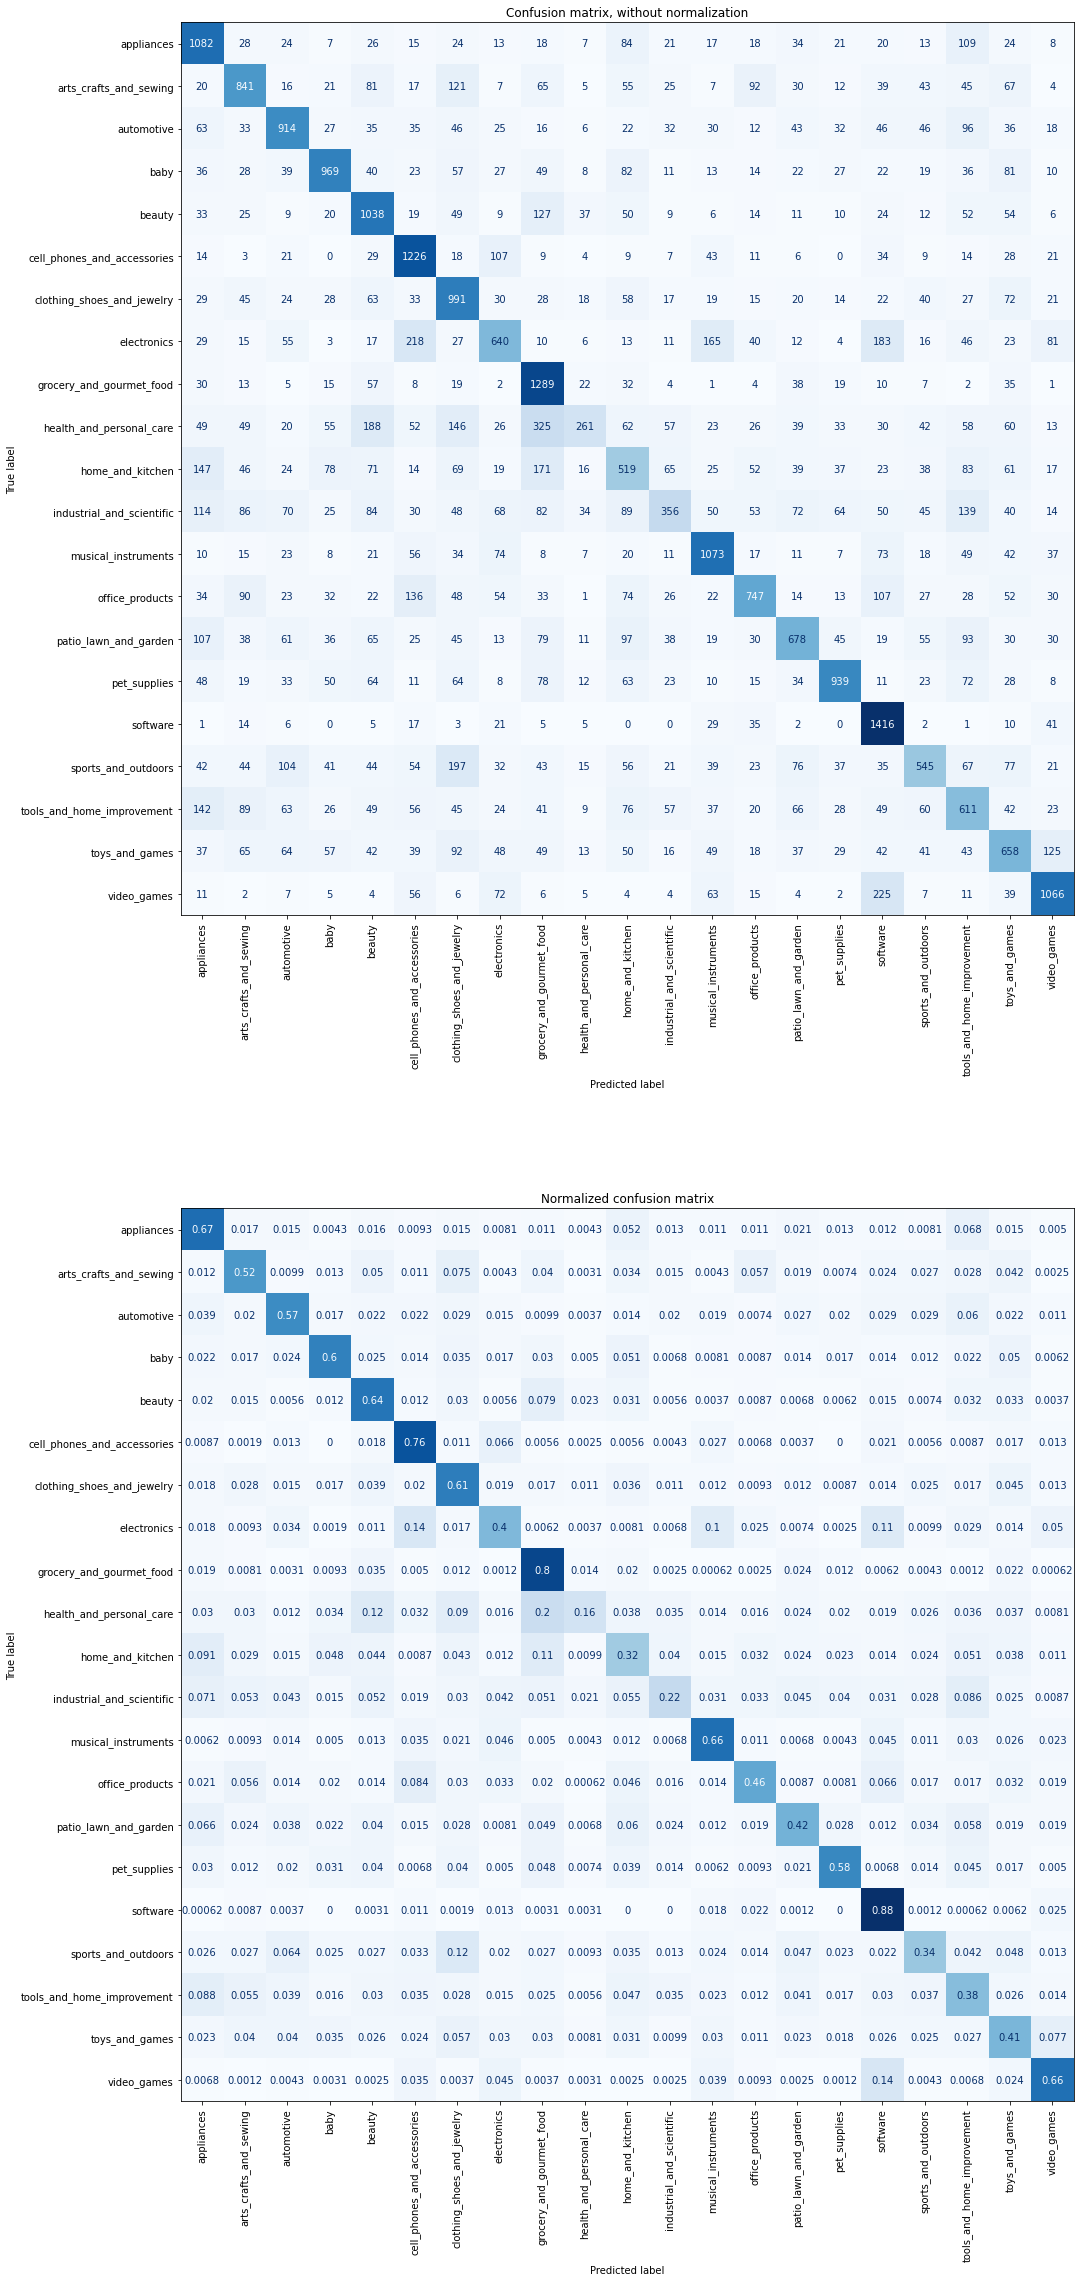

In [57]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
fig, ax = plt.subplots(2, 1, figsize=(20, 40))
i = 0
for title, normalize in titles_options:
    ax[i] = plot_confusion_matrix(
        eval_model, X_test, y_test,
        display_labels=category_list,
        cmap=plt.cm.Blues,
        normalize=normalize,
        xticks_rotation='vertical',
        ax=ax[i])
    ax[i].ax_.set_title(title)
    ax[i].ax_.images[0].colorbar.remove()
    i+=1
plt.show()

In [59]:
y_hat = eval_model.predict(X_test)
f1 = f1_score(y_test, y_hat, average='macro')
f1

0.513162415232602

In [60]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import regex as regex

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mriva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mriva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
def get_stopwords(file='../datasets/stopwords/stopwords.txt'):
    '''
    Description: Retreives stopwords from text file
    ---
    params:

    file:str       - file path
    ---
    output:
    
    set {str} of stopwords:
    {'a', 'set', 'of', 'words', ...}
    ---
    usage:
    >> list(get_stopwords())
    ['a', 'set', 'of', 'words', ...]
    '''
    with open(file,'r') as words:
        stopwords = [word.strip() for word in words]
        return set(stopwords)

In [62]:
def preprocess_text(txt, analyzer = 'stem'):
    '''
    Description: Tokenizes alphabets only. then Choose either to stem or lemmatize.
    ---
    params:

    txt:str       - text to process

    analyzer:str  - 'stem' = PorterStemmer (default)
                  - 'lemm' = WordNetLemmatizer
    ---
    output:
    
    processed text: str 
    ---
    usage:
    >> text = 'I have a 9 year old Badger 1 that needs'
    >> preprocess_text(text, analyzer='stem'))
    'year old badger need'
    # or however the the stemmed output should look like
    '''
    tokenizer = RegexpTokenizer(r'[A-Za-z]+', gaps=False)
    tokens = tokenizer.tokenize(str(txt).lower())
    
    #remove stop words
    all_stopwords = stopwords.words('english')
    all_stopwords.extend(list(get_stopwords()))
    tokens = [w for w in tokens if w not in all_stopwords]
    
    # analyze using lemmatizer
    if analyzer == 'lemm':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(s) for s in tokens]
        
    # analyze using stem
    elif analyzer == 'stem':
        p_stemmer = PorterStemmer()
        tokens = [p_stemmer.stem(s) for s in tokens]
    
    
    text = " ".join(tokens)
    return(text)

In [66]:
def predict_text(text):
    question = text
    question = preprocess_text(question, analyzer='lemm')
    question_vec = vec.transform([question])
    question_proba = eval_model.predict_proba(question_vec)
    return pd.DataFrame({
        'category':category_list,
        'probability':question_proba[0],
    }).sort_values(by='probability', ascending=False)

In [71]:
# testing new entry
predict_text("The JBL speaker doesn't seem to connect to my iPhone. Can you explain how to pair it correctly?")

,category,probability
5,cell_phones_and_accessories,0.231464
12,musical_instruments,0.202616
7,electronics,0.165089
6,clothing_shoes_and_jewelry,0.071062
2,automotive,0.041810
17,sports_and_outdoors,0.033274
13,office_products,0.031090
11,industrial_and_scientific,0.025565
20,video_games,0.024688
9,health_and_personal_care,0.023531


In [70]:
predict_text("I recently bought a dress from your store and I was wondering if you offer alteration services?")

,category,probability
6,clothing_shoes_and_jewelry,0.177716
1,arts_crafts_and_sewing,0.143865
19,toys_and_games,0.067592
9,health_and_personal_care,0.058098
8,grocery_and_gourmet_food,0.055251
5,cell_phones_and_accessories,0.053697
13,office_products,0.047700
4,beauty,0.046604
10,home_and_kitchen,0.035807
17,sports_and_outdoors,0.033346


In [69]:
predict_text("When is the expiry date?")

,category,probability
8,grocery_and_gourmet_food,0.341400
9,health_and_personal_care,0.213253
4,beauty,0.107696
15,pet_supplies,0.055390
11,industrial_and_scientific,0.048505
13,office_products,0.033623
20,video_games,0.019864
3,baby,0.019860
16,software,0.019365
19,toys_and_games,0.017741


In [58]:
# Export Model
filename = f"../models/MulticlassCategoryLabel_Balanced_RandomForestClassifier_EvaluationModel_lemm_02.sav"
joblib.dump(eval_model, filename)

['../models/MulticlassCategoryLabel_Balanced_RandomForestClassifier_EvaluationModel_lemm_02.sav']

exported model is 13BG+ which is too big for my intended deployment. Will proceed to downsample

MulticlassCategoryLabel_Balanced_RandomForestClassifier_EvaluationModel_01
```
stemmed

{'vec__use_idf': True, 'vec__ngram_range': (1, 2), 'vec__min_df': 1, 'vec__max_df': 0.95, 'clf__n_estimators': 1600, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__bootstrap': False}
```
train: 0.67
test: 0.533